####  Credit Card Fraud - Working with unbalanced dataset

__Credit Card Fraud dataset__

================================

The datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, original features and more background information about the data can't be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

__Call libraries__

In [1]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

_Import SMOTE AND ADASYN to balance the dataset_

In [2]:
from imblearn.over_sampling import SMOTE, ADASYN

Using TensorFlow backend.


_Processing data_

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder as ohe
from sklearn.preprocessing import StandardScaler as ss
from sklearn.compose import ColumnTransformer as ct

_Call Modeling module, we will be using XBG for modeling._

In [4]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support

_for ROC graphs & metrics_

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve

_Read data_

In [6]:
os.chdir("../input")
cr = pd.read_csv("creditcard.csv")

_Explore data_

In [7]:
cr.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
cr.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
cr.shape

(284807, 31)

In [11]:
cr.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [12]:
cr.dtypes.value_counts()

float64    30
int64       1
dtype: int64

_ploting_

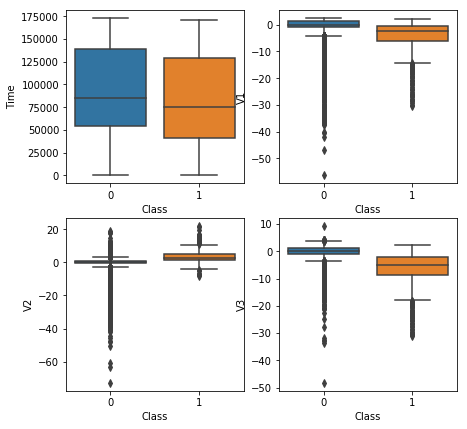

In [13]:
f, axes = plt.subplots(2, 2, figsize=(7, 7))
sns.boxplot(x="Class", y="Time", data=cr, ax=axes[0, 0])
sns.boxplot(x="Class", y="V1", data=cr, ax=axes[0, 1])
sns.boxplot(x="Class", y="V2", data=cr, ax=axes[1, 0])
sns.boxplot(x="Class", y="V3", data=cr, ax=axes[1, 1])
plt.show()

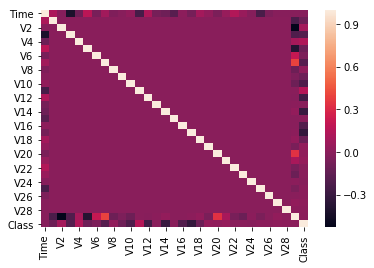

In [14]:
cr.corr()
sns.heatmap(cr.corr())

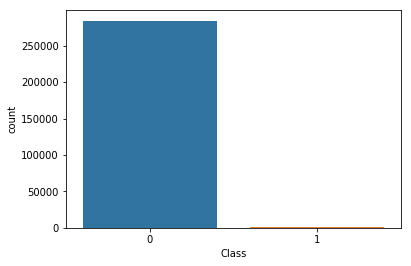

In [15]:
sns.countplot(x='Class', data=cr)

_Just check any columns have missing data_

In [16]:
(cr.isnull()).apply(sum, axis = 0)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Modelling

_Separation into target/predictors_

In [17]:
y = cr.iloc[:,30]
X = cr.iloc[:,0:30]

In [18]:
X.shape              

(284807, 30)

In [19]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [20]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

_Fit and transform_

In [21]:
X_trans = ss().fit_transform(X)
X_trans.shape

(284807, 30)

_Split data into train/test_     

In [22]:
X_train, X_test, y_train, y_test =   train_test_split(X_trans,
                                                      y,
                                                      test_size = 0.3,
                                                      stratify = y
                                                      )


X_train.shape        

(199364, 30)

_XGB Classifier_

In [23]:
xg = XGBClassifier(learning_rate=0.5,
                   reg_alpha= 5,
                   reg_lambda= 0.1
                   )

### SMOTE-Balancing the data

In [24]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

*As we can below the X_res and y_res are having same number of rows, that means we have balanced the data*

In [25]:
X_res.shape

(398040, 30)

In [26]:
y_res.shape

(398040,)

_Fit the data_

In [27]:
xg_res = xg.fit(X_res, y_res)

In [28]:
#Predict
y_pred_xg_res = xg_res.predict(X_test)
y_pred_xg_res

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
y_pred_xg_res_prob = xg_res.predict_proba(X_test)
y_pred_xg_res_prob

array([[9.3364483e-01, 6.6355154e-02],
       [9.9565589e-01, 4.3441183e-03],
       [9.9790472e-01, 2.0952567e-03],
       ...,
       [9.9979103e-01, 2.0895043e-04],
       [9.9438208e-01, 5.6179101e-03],
       [8.2841033e-01, 1.7158966e-01]], dtype=float32)

In [30]:
#Accuracy
print ('Accuracy using XGB and SMOTE',accuracy_score(y_test,y_pred_xg_res))

Accuracy using XGB and SMOTE 0.9906487365846237


In [31]:
#Confusion Matrix
confusion_matrix(y_test,y_pred_xg_res)

array([[84513,   782],
       [   17,   131]])

In [32]:
fpr_xg_res, tpr_xg_res, thresholds = roc_curve(y_test,
                                 y_pred_xg_res_prob[: , 1],
                                 pos_label= 1
                                 )


In [33]:
#Precion, Recall and F1 Score
p_xg_res,r_xg_res,f_xg_res,_ = precision_recall_fscore_support(y_test,y_pred_xg_res)

In [34]:
p_xg_res,r_xg_res,f_xg_res

(array([0.99979889, 0.14348302]),
 array([0.99083182, 0.88513514]),
 array([0.99529516, 0.24693685]))

In [35]:
print ('AUC using XGB and SMOTE',auc(fpr_xg_res,tpr_xg_res))

AUC using XGB and SMOTE 0.965667286666466


_ROC Curve_

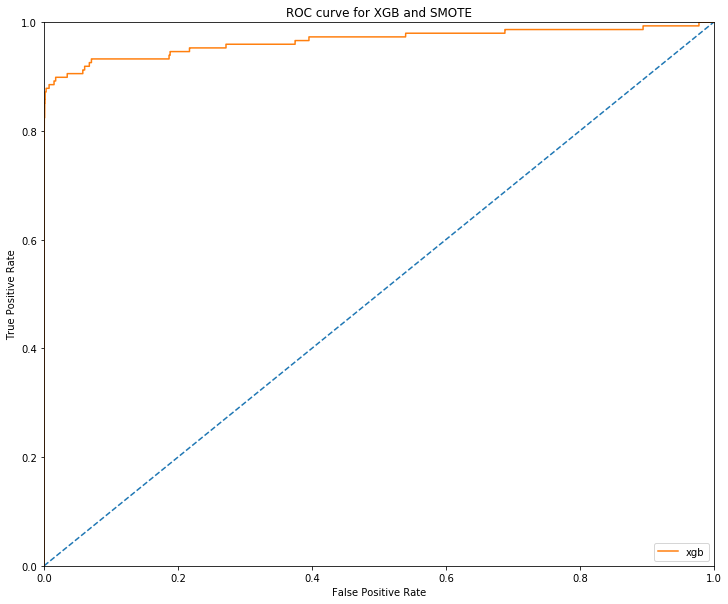

In [36]:
fig = plt.figure(figsize=(12,10)) 
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], ls="--")   
ax.set_xlabel('False Positive Rate')  
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for XGB and SMOTE')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.plot(fpr_xg_res, tpr_xg_res, label = "xgb")
ax.legend(loc="lower right")
plt.show()

## ADASYN-Balancing the data

In [37]:
ad = ADASYN(random_state=42)
X_ada, y_ada = sm.fit_sample(X_train, y_train)

In [38]:
X_ada.shape

(398040, 30)

In [39]:
y_ada.shape

(398040,)

In [40]:
xg_ada = xg.fit(X_ada, y_ada)

In [41]:
y_pred_xg_ada = xg_ada.predict(X_test)
y_pred_xg_ada

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
y_pred_xg_ada_prob = xg_ada.predict_proba(X_test)
y_pred_xg_ada_prob

array([[9.3364483e-01, 6.6355154e-02],
       [9.9565589e-01, 4.3441183e-03],
       [9.9790472e-01, 2.0952567e-03],
       ...,
       [9.9979103e-01, 2.0895043e-04],
       [9.9438208e-01, 5.6179101e-03],
       [8.2841033e-01, 1.7158966e-01]], dtype=float32)

In [43]:
print ('Accuracy using XGB and ADASYN',accuracy_score(y_test,y_pred_xg_ada))

Accuracy using XGB and ADASYN 0.9906487365846237


In [44]:
confusion_matrix(y_test,y_pred_xg_ada)

array([[84513,   782],
       [   17,   131]])

In [45]:
fpr_xg_ada, tpr_xg_ada, thresholds = roc_curve(y_test,
                                 y_pred_xg_ada_prob[: , 1],
                                 pos_label= 1
                                 )

In [46]:
p_xg_ada,r_xg_ada,f_xg_ada,_ = precision_recall_fscore_support(y_test,y_pred_xg_ada)

In [47]:
p_xg_ada,r_xg_ada,f_xg_ada

(array([0.99979889, 0.14348302]),
 array([0.99083182, 0.88513514]),
 array([0.99529516, 0.24693685]))

In [48]:
print ('AUC using XGB and ADASYN',auc(fpr_xg_ada,tpr_xg_ada))

AUC using XGB and ADASYN 0.965667286666466


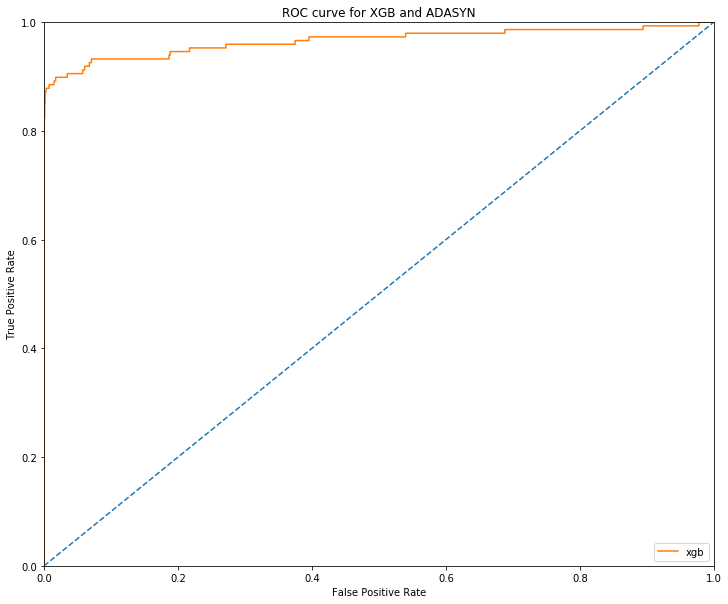

In [49]:
fig = plt.figure(figsize=(12,10))        
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], ls="--")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for XGB and ADASYN')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.plot(fpr_xg_ada, tpr_xg_ada, label = "xgb")
ax.legend(loc="lower right")
plt.show()